In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.__stdout__

In [2]:
# dataset
from torch.utils.data import Dataset, DataLoader

def add_shot_noise(image):
    # randomly flip the pixel with probability 0.2
    
    # if s==1 then flip;
    # `image + 0.5*s` stratify `image` pixel into {0, 0.5, 1, 1.5}
    # 0.5 indicates the value needs to be fliped to 1
    # 1.5 indicates the value needs to be fliped to 0
    s = 0.5 * np.random.binomial(1, 0.2, 784)
    tmp_img = image + s
    flip_zero_idx = np.where(tmp_img == 0.5)[0]
    flip_one_idx = np.where(tmp_img == 1.5)[0]
    tmp_img[flip_zero_idx] = 1.
    tmp_img[flip_one_idx] = 0.
    return tmp_img
    

class NoisyData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        image = image.reshape(784)
        
        image = add_shot_noise(image)
        return image, label

def get_dataloader(x, y, batch_size, num_worker, shuffle):
    '''Use PyTorch Dataset to enable multiprocessing to prepare data.
    '''
    dataset = NoisyData(x, y)
    
    init_fun = np.random.seed()
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_worker,
        worker_init_fn=init_fun
    )
    return dataloader

Variational Auto-encoder ELBO:

\begin{align}
& E_{q(z|x)} [\log p(x,z) - \log q(z|x)] \\
= & E_{q(z|x)} [\log p(x|z)] - KL[q(z|x)||p(z)] \\
\propto & - \sum_{i=1}^N (\hat x_i - x_i)^2 - \sum_{i=1}^K KL(q_{z_i|x}||p(z_i))
\end{align}
where $N$ and $K$ is the dimension of the input and latent variable, respectively.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

from datetime import datetime
def print_log(*args):
    print("[{}]".format(datetime.now()), *args)
    sys.stdout.flush()

class VariationalAutoEncoder:
    def __init__(self, x_dim, z_dim, net_size, lr=0.001, kl_weight=1.0):
        
        # 'z_dim, activation, loss' can be tuned
        
        # reset the default graph otherwise the variable initialization will get
        # slower because all models create the variables and operations in the
        # same graph
        tf.reset_default_graph()
        
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.lr = lr
        self.kl_weight = kl_weight
        
        with tf.compat.v1.variable_scope('placeholder'):
            x_shape = [None] + [self.x_dim]
            self.x = tf.placeholder(
                tf.float32, 
                shape=x_shape)
        
        with tf.compat.v1.variable_scope('networks'):
            self.recog = keras.Sequential(
                [
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(self.z_dim*2, activation=None),
                ]
            )
            self.gen = keras.Sequential(
                [
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(net_size, activation='relu'),
                    layers.Dense(self.x_dim, activation=None),
                ]
            )
        
        with tf.compat.v1.variable_scope('z'):
            self.p_z = tfd.Normal(
                loc=[0.] * self.z_dim,
                scale=[1.] * self.z_dim,
                name='p_z_dist')
            
            self.z_param = self.recog(self.x)
            self.z_mean = self.z_param[:, :self.z_dim]
            self.z_std = tf.math.softplus(self.z_param[:, self.z_dim:])

            self.q_z = tfd.Normal(
                loc=self.z_mean,
                scale=self.z_std,
                name='q_z_dist')
            
            self.z = self.q_z.sample()
            
        with tf.compat.v1.variable_scope('x'):
            self.re_x_logit = self.gen(self.z)
            self.p_re_x = tfd.Bernoulli(logits=self.re_x_logit, name='p_x_z_dist')
            self.re_x = self.p_re_x.mean()
        
        with tf.compat.v1.variable_scope('training_loss'):
            self.rec_error = -tf.reduce_sum(
                self.p_re_x.log_prob(self.x), axis=-1)
            self.kl_loss = tf.reduce_sum(tfd.kl_divergence(self.q_z, self.p_z, name='KL'), axis=-1)
            self.nelbo = self.rec_error + self.kl_weight * self.kl_loss
            self.ave_nelbo = tf.reduce_mean(self.nelbo)
        
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.ave_nelbo)
        
        # sample from prior
        self.z_from_prior = self.p_z.sample()
        self.x_sample_logit = self.gen(tf.expand_dims(self.z_from_prior, axis=0))
        self.p_x_sample = tfd.Bernoulli(logits=self.x_sample_logit)
        self.x_sample = self.p_x_sample.mean()
        
    # initialization
    def init_session(self):
        # Initializing the variables
        init = tf.global_variables_initializer()

        # launch a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = False #True
        self.sess = tf.Session(config=config)

        self.sess.run(init)
        
    def train(self, tr_loader, no_epochs=500, te_loader=None):
        costs = []
        rec_error = []
        kl_loss = []
        
        for epoch_idx in range(no_epochs):
            epoch_cost = 0.
            epoch_lik_cost = 0.
            epoch_kl_cost = 0.
            for batch_idx, tr_batch in enumerate(tr_loader):
                tr_x, _, = tr_batch
                _, cost, kl, rec = self.sess.run(
                    [
                        self.train_step,
                        self.ave_nelbo,
                        self.kl_loss,
                        self.rec_error
                    ],
                    feed_dict={
                        self.x: tr_x
                    }
                )
                
                epoch_cost += cost
                epoch_lik_cost += np.mean(rec)
                epoch_kl_cost += np.mean(kl)
                
                costs.append(cost)
                rec_error.append(np.mean(rec))
                kl_loss.append(np.mean(kl))
                
            batch_idx += 1
            epoch_cost /= batch_idx
            epoch_lik_cost /= batch_idx
            epoch_kl_cost /= batch_idx
            
            print_log("Epoch:", '%04d' % (epoch_idx+1), 
                "total cost=", 
                "{:.9f}".format(epoch_cost), 
                "log-likelihood term=", 
                "{:.9f}".format(epoch_lik_cost), 
                "kl/regluarization term=", 
                "{:.9f}".format(epoch_cost - epoch_lik_cost))
            
        return costs, rec_error, kl_loss

In [4]:
mini_batchsize = 64
no_epochs = 50
lr = 0.001
z_dim = 100
net_size = 200

# data
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = np.squeeze(y_train) # (60000,)
x_test = x_test.astype('float32')
y_test = np.squeeze(y_test) # (10000,)
x_train /= 255
x_test /= 255
x_train = (x_train > 0.5).astype(np.float32)
x_test = (x_test > 0.5).astype(np.float32)

# which label
digit = [[1], [5]]
def get_digits(x, y, digit):
    where_arg = np.bitwise_or.reduce(y == digit, axis=0)
    digit_idx = np.where(where_arg)[0]
    digit_idx[0]
    x = x[digit_idx]
    y = y[digit_idx]
    return x, y
x_train, y_train = get_digits(x_train, y_train, digit)
x_test, y_test = get_digits(x_test, y_test, digit)

mnist_tr_loader = get_dataloader(x_train, y_train, mini_batchsize, 4, True)

# model
vae = VariationalAutoEncoder(x_dim=784, z_dim=z_dim, net_size=net_size, lr=lr)
vae.init_session()

# train
costs, rec_error, kl_loss = vae.train(mnist_tr_loader, no_epochs=no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[2021-06-06 13:23:41.991836] Epoch: 0001 total cost= 439.920840278 log-likelihood term= 438.717938169 kl/regluarization term= 1.202902110
[2021-06-06 13:23:43.201461] Epoch: 0002 total cost= 433.741184255 log-likelihood term= 433.409481508 kl/regluarization term= 0.331702747
[2021-06-06 13:23:44.475700] Epoch: 0003 total cost= 433.275896801 log-likelihood term= 433.006632700 kl/regluarization term= 0.269264101
[2021-06-06 13:23:45.735820] Epoch: 0004 total cost= 432.938020716 log-likelihood term= 432.654224975 kl/regluarization term= 0.283795741
[2021-06-06 13:23:46.985083] Epoch: 0005 total cost= 430.215874957 log-likelihood term= 428.993901917 kl/regluarization term= 1.221973040
[2021-06-06 13:23:48.278592] Epoch: 0006 total cost= 429.182262161 log-likelihood term= 427.731698720 kl/regluarization term= 1.450563441
[2021-06-06 13:23:49.557072] Epoch: 0007 total cost= 428.463377788 log-likelihood term= 426

/home/aodongl1/.conda/envs/py3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: tight_layout : falling back to Agg renderer


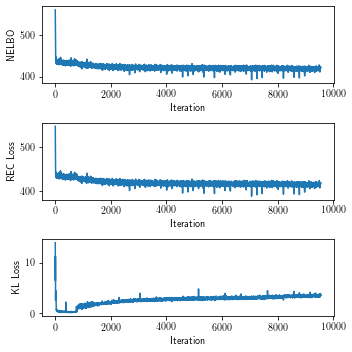

In [5]:
fig = plt.Figure(figsize=[5,5])
axes = fig.subplots(3,1)

ax = axes[0]
ax.plot(costs)
ax.set_xlabel('Iteration')
ax.set_ylabel('NELBO')

ax = axes[1]
ax.plot(rec_error)
ax.set_xlabel('Iteration')
ax.set_ylabel('REC Loss')

ax = axes[2]
ax.plot(kl_loss)
ax.set_xlabel('Iteration')
ax.set_ylabel('KL Loss')

fig.tight_layout()
fig

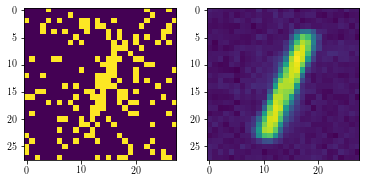

In [6]:
# reconstruct a test image
x_te = x_test[0]
x_te = x_te.reshape(784)
x_te = add_shot_noise(x_te)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

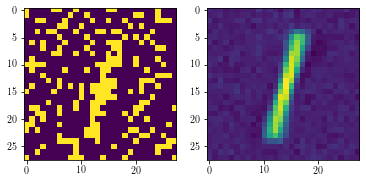

In [7]:
# reconstruct a test image
x_te = x_test[1]
x_te = x_te.reshape(784)
x_te = add_shot_noise(x_te)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

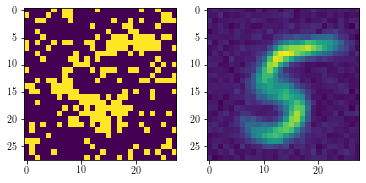

In [8]:
# reconstruct a test image
x_te = x_test[2]
x_te = x_te.reshape(784)
x_te = add_shot_noise(x_te)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

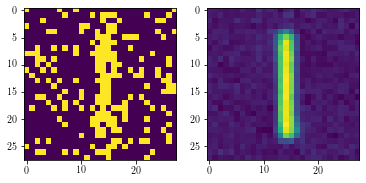

In [9]:
# reconstruct a test image
x_te = x_test[3]
x_te = x_te.reshape(784)
x_te = add_shot_noise(x_te)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

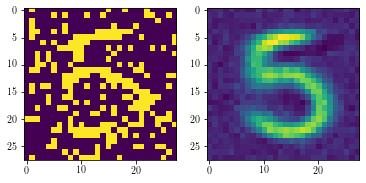

In [10]:
# reconstruct a test image
x_te = x_test[4]
x_te = x_te.reshape(784)
x_te = add_shot_noise(x_te)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

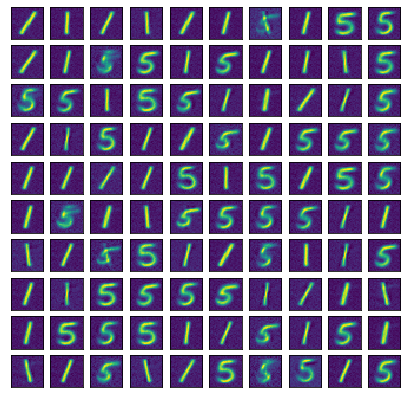

In [11]:
# samples
fig = plt.Figure(figsize=(7,7))
axes = fig.subplots(10,10)

for i in range(10):
    for j in range(10):
        ax = axes[i,j]
        
        re_x = vae.sess.run([vae.x_sample])[0]
        
        ax.imshow(re_x.reshape(28,28))
        ax.set_xticks([])
        ax.set_xticks([], minor=True)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)

fig